In [1]:
import pandas as pd
df = pd.read_csv("/home/marko/projects/tf216/pgdatafinal.csv")

In [2]:
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
for idx, col_name in enumerate(df.columns):
    print(f"Index: {idx}, Column Name: {col_name}")

Index: 0, Column Name: TEMP
Index: 1, Column Name: RHUM
Index: 2, Column Name: WDSP
Index: 3, Column Name: MAXT
Index: 4, Column Name: MINT


In [3]:
ry = pd.read_csv("/home/marko/projects/tf216/ry2018.csv")
ry['DATE'] = pd.to_datetime(ry['DATE'])
ry = ry.set_index('DATE')
ry.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-01-01 to 2018-12-31
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TEMP     365 non-null    float64
 1   MAXTEMP  365 non-null    float64
 2   MINTEMP  365 non-null    float64
 3   DEWP     365 non-null    float64
 4   HUM      365 non-null    float64
 5   WS       365 non-null    float64
 6   MAXWS    365 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 22.8 KB


In [4]:
df_train = df["2002-01-01":"2015-12-31"]
df_valid = df["2016-01-01":"2017-12-31"]
df_test = df["2018-01-01":"2018-12-31"]

In [5]:
import tensorflow as tf

def split_inputs_and_targets(time_series, ahead=365, target_cols=0):
	return time_series[:, :-ahead], time_series[:, -ahead:, target_cols]

seq_length = 365
train_ds = tf.keras.utils.timeseries_dataset_from_array(
	df_train.to_numpy(),
	targets=None,
	sequence_length=seq_length + 365,
	batch_size=32,
	shuffle=True,
	seed=42
).map(split_inputs_and_targets)


valid_ds = tf.keras.utils.timeseries_dataset_from_array(
	df_valid.to_numpy(),
	targets=None,
	sequence_length=seq_length + 365,
	batch_size=32,
	shuffle=False
).map(split_inputs_and_targets)

2025-03-10 20:46:37.959669: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 20:46:37.990619: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-10 20:46:41.066421: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-10 20:46:41.075570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devi

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

Y_ref = ry.iloc[:, 0].to_numpy()
Y_test = df_test.iloc[:, 0].to_numpy()

mae_ref = mean_absolute_error(Y_test, Y_ref)
print(f'Mean Absolute Error (MAE): {mae_ref}')

rmse_ref = np.sqrt(mean_squared_error(Y_test, Y_ref))
print(f'Root Mean Squared Error (RMSE): {rmse_ref}')

X = df_valid.to_numpy()[np.newaxis, :seq_length]

Mean Absolute Error (MAE): 3.398904109589041
Root Mean Squared Error (RMSE): 4.313210036842376


In [7]:
lstm_32 = tf.keras.Sequential([
	tf.keras.layers.LSTM(32, input_shape=[None, 5]),
	tf.keras.layers.Dense(365)
])
lstm_32.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_32 = lstm_32.fit(train_ds, validation_data=valid_ds, epochs=100)
lstm_32.save('models/lstm_32.keras')

/home/marko/miniconda3/envs/tf216/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


2025-03-02 19:13:35.127690: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 323.2323 - mae: 15.8784 - val_loss: 238.6943 - val_mae: 13.0098
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 186.0445 - mae: 11.2379 - val_loss: 156.2296 - val_mae: 10.1290
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 121.3159 - mae: 8.8617 - val_loss: 114.9697 - val_mae: 8.6382
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 90.5944 - mae: 7.7883 - val_loss: 95.5159 - val_mae: 7.9728
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 77.5891 - mae: 7.3549 - val_loss: 87.4678 - val_mae: 7.7323
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 72.7139 - mae: 7.2119 - val_loss: 84.2883 - val_mae: 7.6411
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 71.3459 - mae: 7.1848 - val_loss: 83.0314 - val_mae: 7.6013
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 70.9138 - mae: 7.1779 - val_loss: 82.6918 - val_mae: 7.5913
Epoch 9/100
137/137 ━━━━━━

In [8]:
from tensorflow.keras.models import load_model
lstm_32 = load_model('models/lstm_32.keras')
history_lstm_32_2 = lstm_32.fit(train_ds, validation_data=valid_ds, epochs=20)
lstm_32.save('models/lstm_32.keras')

Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 14.4862 - mae: 3.0322 - val_loss: 27.6077 - val_mae: 4.4183
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 14.0594 - mae: 2.9884 - val_loss: 15.9449 - val_mae: 3.2448
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 13.8981 - mae: 2.9735 - val_loss: 28.1423 - val_mae: 4.4819
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 13.3944 - mae: 2.9189 - val_loss: 28.0560 - val_mae: 4.4787
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 13.2271 - mae: 2.9006 - val_loss: 13.8857 - val_mae: 3.0092
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 13.4742 - mae: 2.9314 - val_loss: 28.3775 - val_mae: 4.5090
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 12.9937 - mae: 2.8764 - val_loss: 27.6586 - val_mae: 4.4342
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 12.6475 - mae: 2.8372 - val_loss: 27.3013 - val_mae: 4.4075
Epoch 9/20
137/137 ━━━━━━━━━━━━━

In [9]:
lstm_32 = tf.keras.models.load_model('models/lstm_32.keras')
Y_lstm_32 = lstm_32.predict(X)
Y_lstm_32 = Y_lstm_32.flatten()

mae_lstm_32 = mean_absolute_error(Y_test, Y_lstm_32)
print(f'Mean Absolute Error (MAE): {mae_lstm_32}')

rmse_lstm_32 = np.sqrt(mean_squared_error(Y_test, Y_lstm_32))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_32}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Mean Absolute Error (MAE): 2.8807396332205153
Root Mean Squared Error (RMSE): 3.541127903443409


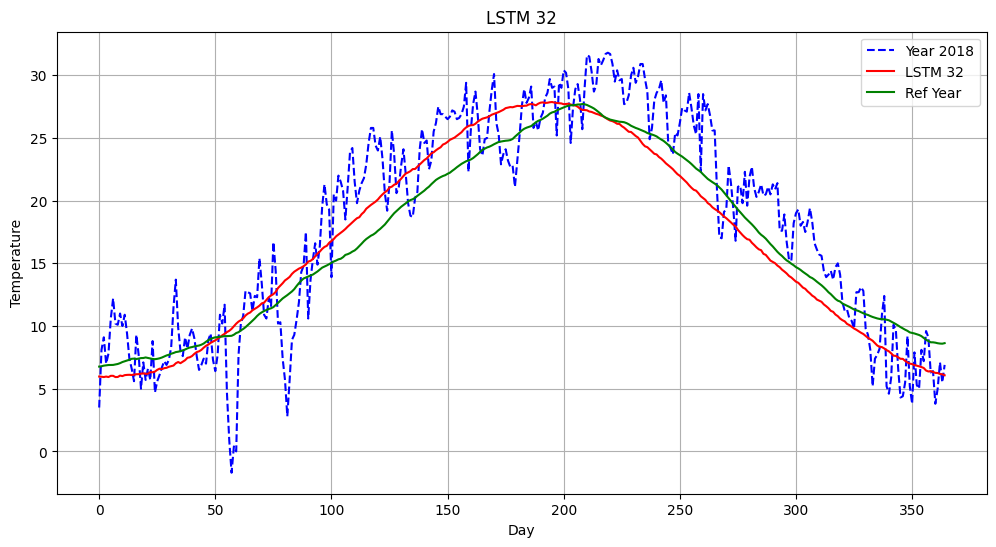

In [10]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_lstm_32, label="LSTM 32", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("LSTM 32")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_64 = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=[None, 5]),
    tf.keras.layers.Dense(365)
])

lstm_64.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_64 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=100)
lstm_64.save('models/lstm_64.keras')

/home/marko/miniconda3/envs/tf216/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


2025-03-02 02:08:28.235117: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 291.1927 - mae: 14.8119 - val_loss: 155.0207 - val_mae: 10.0806
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 112.6341 - mae: 8.5575 - val_loss: 94.6679 - val_mae: 7.9598
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 75.8791 - mae: 7.3049 - val_loss: 84.5543 - val_mae: 7.6634
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 71.2152 - mae: 7.1824 - val_loss: 82.7915 - val_mae: 7.5989
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 70.9338 - mae: 7.1852 - val_loss: 82.9071 - val_mae: 7.6071
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 70.8104 - mae: 7.1815 - val_loss: 82.9823 - val_mae: 7.6110
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 70.9014 - mae: 7.1876 - val_loss: 82.8789 - val_mae: 7.6061
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 70.8400 - mae: 7.1839 - val_loss: 83.2532 - val_mae: 7.6256
Epoch 9/100
137/137 ━━━━━━━━━━━

In [8]:
lstm_64 = tf.keras.models.load_model('models/lstm_64.keras')
Y_lstm_64 = lstm_64.predict(X)
Y_lstm_64 = Y_lstm_64.flatten()

mae_lstm_64 = mean_absolute_error(Y_test, Y_lstm_64)
print(f'Mean Absolute Error (MAE): {mae_lstm_64}')

rmse_lstm_64 = np.sqrt(mean_squared_error(Y_test, Y_lstm_64))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_64}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Mean Absolute Error (MAE): 2.803059309606683
Root Mean Squared Error (RMSE): 3.525008702832247


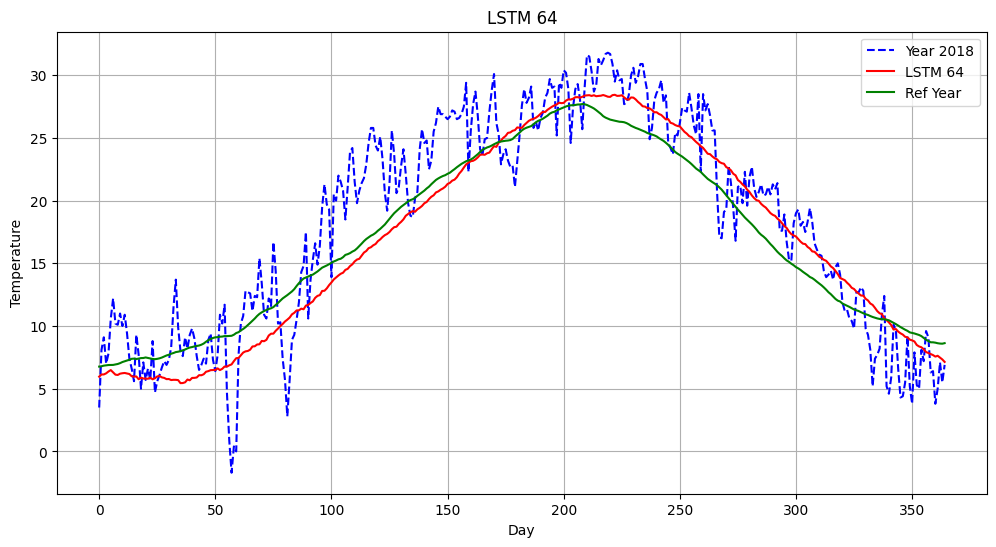

In [11]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_lstm_64, label="LSTM 64", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("LSTM 64")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365)
])

lstm_128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_128 = lstm_128.fit(train_ds, validation_data=valid_ds, epochs=80)
lstm_128.save('models/lstm_128.keras')

Epoch 1/80


2025-03-02 02:21:17.131623: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 248.6893 - mae: 13.3299 - val_loss: 93.6253 - val_mae: 7.9441
Epoch 2/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 73.4479 - mae: 7.2411 - val_loss: 83.5689 - val_mae: 7.6378
Epoch 3/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 70.8917 - mae: 7.1869 - val_loss: 84.6193 - val_mae: 7.6922
Epoch 4/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 70.9158 - mae: 7.1872 - val_loss: 84.1107 - val_mae: 7.6679
Epoch 5/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 70.9682 - mae: 7.1898 - val_loss: 84.5920 - val_mae: 7.6914
Epoch 6/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 70.8649 - mae: 7.1844 - val_loss: 84.4947 - val_mae: 7.6866
Epoch 7/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 70.9297 - mae: 7.1885 - val_loss: 83.9538 - val_mae: 7.6582
Epoch 8/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 70.5593 - mae: 7.1678 - val_loss: 84.4553 - val_mae: 7.6851
Epoch 9/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 3

In [8]:
from tensorflow.keras.models import load_model
lstm_128 = load_model('models/lstm_128.keras')
history_lstm_128_2 = lstm_128.fit(train_ds, validation_data=valid_ds, epochs=20)
lstm_128.save('models/lstm_128.keras')

Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 13.1566 - mae: 2.8959 - val_loss: 12.8322 - val_mae: 2.7402
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 12.7983 - mae: 2.8576 - val_loss: 15.2154 - val_mae: 3.2475
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 12.7002 - mae: 2.8457 - val_loss: 14.3320 - val_mae: 2.9350
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 12.4403 - mae: 2.8182 - val_loss: 32.6601 - val_mae: 4.8757
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 12.2370 - mae: 2.7965 - val_loss: 13.8611 - val_mae: 2.8910
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 11.9971 - mae: 2.7688 - val_loss: 13.5256 - val_mae: 3.0151
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 11.8904 - mae: 2.7575 - val_loss: 15.2630 - val_mae: 3.2672
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 12.0642 - mae: 2.7732 - val_loss: 10.6244 - val_mae: 2.4905
Epoch 9/20
137/137 ━━━━━━━━━━━━━

In [9]:
lstm_128 = tf.keras.models.load_model('models/lstm_128.keras')
Y_lstm_128 = lstm_128.predict(X)
Y_lstm_128 = Y_lstm_128.flatten()

mae_lstm_128 = mean_absolute_error(Y_test, Y_lstm_128)
print(f'Mean Absolute Error (MAE): {mae_lstm_128}')

rmse_lstm_128 = np.sqrt(mean_squared_error(Y_test, Y_lstm_128))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_128}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Mean Absolute Error (MAE): 2.940469617190426
Root Mean Squared Error (RMSE): 3.8052044657998643


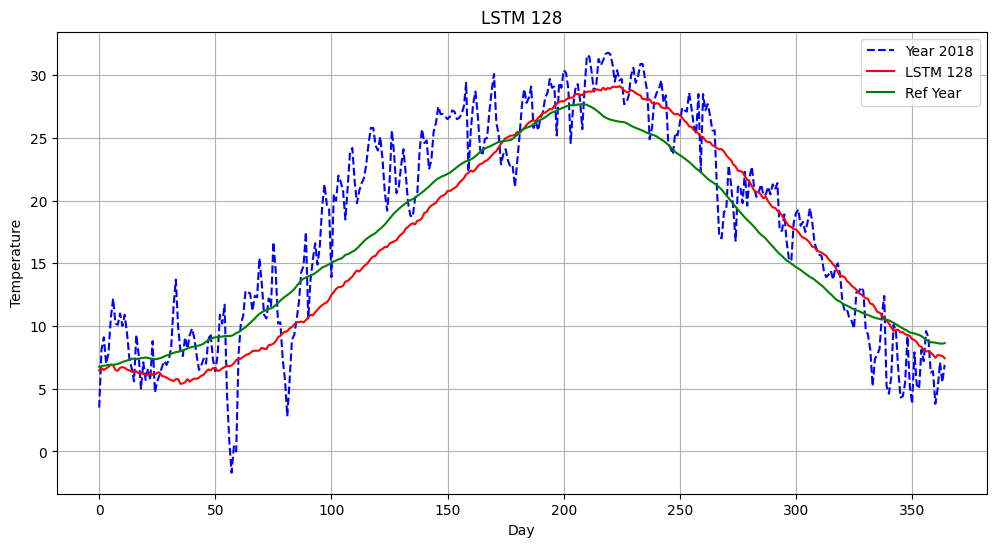

In [10]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_lstm_128, label="LSTM 128", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("LSTM 128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_256 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dense(365)
])

lstm_256.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_256 = lstm_256.fit(train_ds, validation_data=valid_ds, epochs=60)
lstm_256.save('models/lstm_256.keras')

Epoch 1/60


2025-03-02 03:00:20.476886: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 196.4470 - mae: 11.5197 - val_loss: 84.1506 - val_mae: 7.6691
Epoch 2/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 70.5645 - mae: 7.1680 - val_loss: 82.0035 - val_mae: 7.5633
Epoch 3/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 68.5148 - mae: 7.0581 - val_loss: 82.0684 - val_mae: 7.5694
Epoch 4/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 66.8227 - mae: 6.9625 - val_loss: 79.2654 - val_mae: 7.4316
Epoch 5/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 65.2607 - mae: 6.8742 - val_loss: 71.9077 - val_mae: 7.0406
Epoch 6/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 61.2700 - mae: 6.6434 - val_loss: 66.2498 - val_mae: 6.7379
Epoch 7/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 57.8164 - mae: 6.4367 - val_loss: 59.0939 - val_mae: 6.3380
Epoch 8/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 54.9398 - mae: 6.2569 - val_loss: 56.0527 - val_mae: 6.1712
Epoch 9/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 3

In [8]:
lstm_256 = tf.keras.models.load_model('models/lstm_256.keras')
Y_lstm_256 = lstm_256.predict(X)
Y_lstm_256 = Y_lstm_256.flatten()

mae_lstm_256 = mean_absolute_error(Y_test, Y_lstm_256)
print(f'Mean Absolute Error (MAE): {mae_lstm_256}')

rmse_lstm_256 = np.sqrt(mean_squared_error(Y_test, Y_lstm_256))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_256}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Mean Absolute Error (MAE): 2.7447891002811797
Root Mean Squared Error (RMSE): 3.3421999014139727


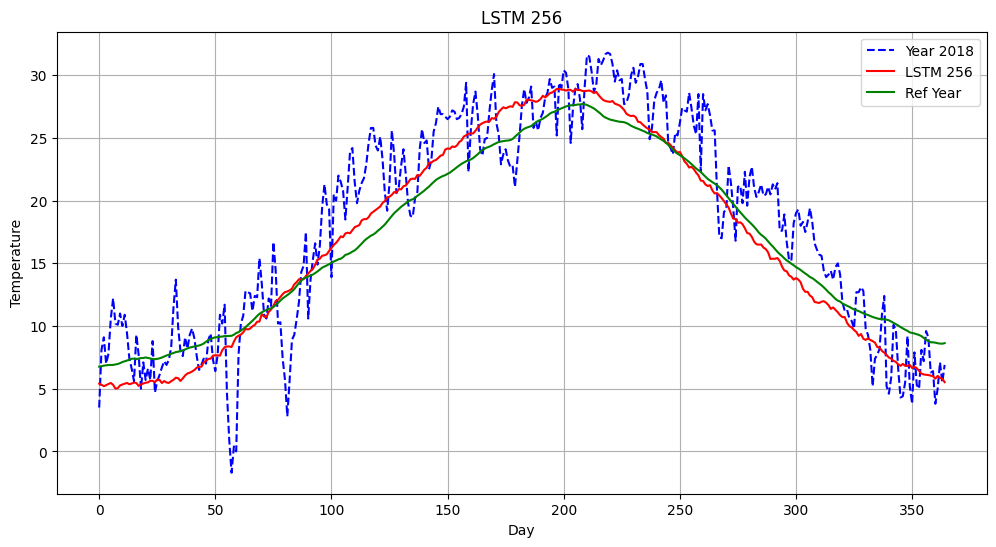

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_lstm_256, label="LSTM 256", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("LSTM 256")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_512 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(512),
    tf.keras.layers.Dense(365)
])

lstm_512.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_512 = lstm_512.fit(train_ds, validation_data=valid_ds, epochs=20)
lstm_512.save('models/lstm_512.keras')

Epoch 1/20


2025-03-04 21:53:58.126421: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 155.9439 - mae: 10.1162 - val_loss: 76.0248 - val_mae: 7.2616
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 62.7021 - mae: 6.7248 - val_loss: 63.5268 - val_mae: 6.6227
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 55.0860 - mae: 6.2672 - val_loss: 53.6375 - val_mae: 6.0684
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 49.4292 - mae: 5.8956 - val_loss: 47.0809 - val_mae: 5.6846
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 44.4759 - mae: 5.5555 - val_loss: 37.9566 - val_mae: 5.0739
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 39.9511 - mae: 5.2442 - val_loss: 37.3377 - val_mae: 5.0102
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 35.8806 - mae: 4.9454 - val_loss: 33.2115 - val_mae: 4.6893
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 29.4407 - mae: 4.4442 - val_loss: 36.1536 - val_mae: 4.8004
Epoch 9/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4

In [8]:
lstm_512 = tf.keras.models.load_model('models/lstm_512.keras')
Y_lstm_512 = lstm_512.predict(X)
Y_lstm_512 = Y_lstm_512.flatten()

mae_lstm_512 = mean_absolute_error(Y_test, Y_lstm_512)
print(f'Mean Absolute Error (MAE): {mae_lstm_512}')

rmse_lstm_512 = np.sqrt(mean_squared_error(Y_test, Y_lstm_512))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_512}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Mean Absolute Error (MAE): 2.9488121544824883
Root Mean Squared Error (RMSE): 3.6571072319291797


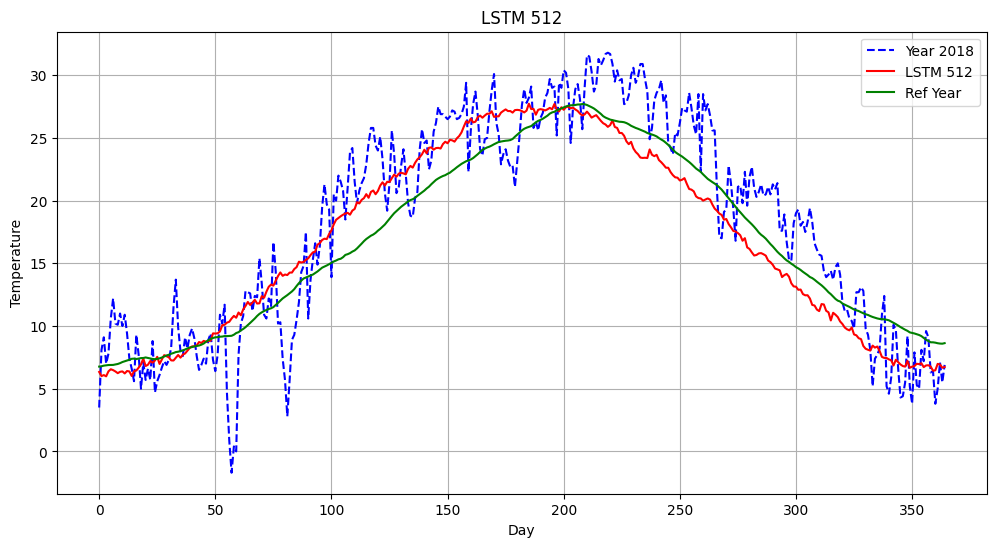

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_lstm_512, label="LSTM 512", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("LSTM 512")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(365)
])

lstm_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_3232 = lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=100)
lstm_3232.save('models/lstm_3232.keras')

Epoch 1/100


2025-03-02 17:44:41.028880: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 320.2781 - mae: 15.7864 - val_loss: 237.7597 - val_mae: 12.9973
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 187.9803 - mae: 11.3098 - val_loss: 156.3070 - val_mae: 10.1362
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 122.9395 - mae: 8.9201 - val_loss: 114.8037 - val_mae: 8.6233
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 91.5142 - mae: 7.8196 - val_loss: 95.1455 - val_mae: 7.9453
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 78.0084 - mae: 7.3677 - val_loss: 87.0660 - val_mae: 7.7130
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 72.8659 - mae: 7.2154 - val_loss: 83.9659 - val_mae: 7.6283
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 71.3920 - mae: 7.1854 - val_loss: 82.8117 - val_mae: 7.5928
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 70.9251 - mae: 7.1777 - val_loss: 82.5489 - val_mae: 7.5861
Epoch 9/100
137/137 ━━━━━━

In [8]:
lstm_3232 = tf.keras.models.load_model('models/lstm_3232.keras')
Y_lstm_3232 = lstm_3232.predict(X)
Y_lstm_3232 = Y_lstm_3232.flatten()

mae_lstm_3232 = mean_absolute_error(Y_test, Y_lstm_3232)
print(f'Mean Absolute Error (MAE): {mae_lstm_3232}')

rmse_lstm_3232 = np.sqrt(mean_squared_error(Y_test, Y_lstm_3232))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_3232}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
Mean Absolute Error (MAE): 2.7903229820565
Root Mean Squared Error (RMSE): 3.5072211248659038


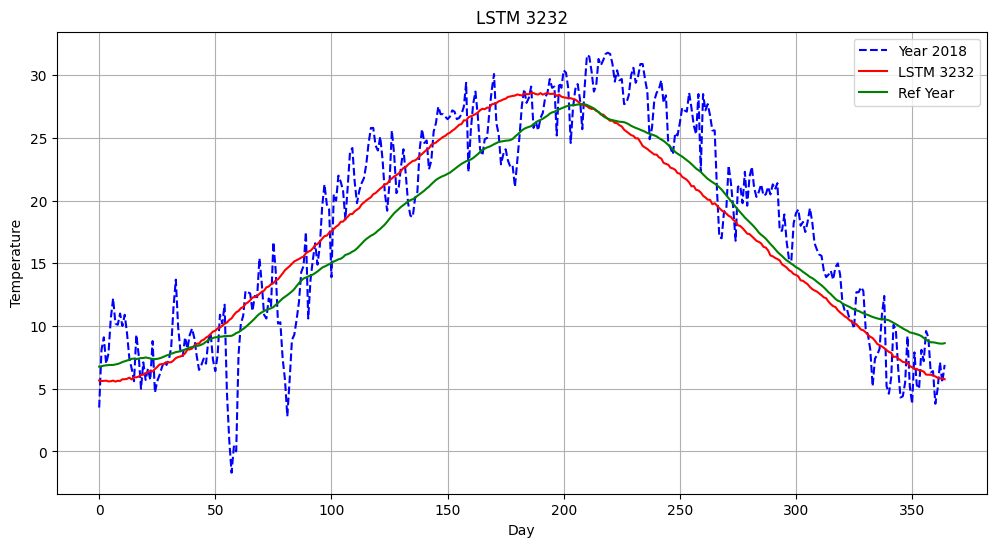

In [ ]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_lstm_3232, label="LSTM 3232", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("LSTM 3232")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(365)
])

lstm_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_6464 = lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=70)
lstm_6464.save('models/lstm_6464.keras')

Epoch 1/70


2025-03-10 20:47:21.784803: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 289.9614 - mae: 14.7740 - val_loss: 157.8938 - val_mae: 10.1546
Epoch 2/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 114.7395 - mae: 8.6324 - val_loss: 95.7509 - val_mae: 7.9827
Epoch 3/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 76.4009 - mae: 7.3203 - val_loss: 84.7808 - val_mae: 7.6702
Epoch 4/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 71.2747 - mae: 7.1832 - val_loss: 82.8002 - val_mae: 7.5982
Epoch 5/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 70.9367 - mae: 7.1850 - val_loss: 82.8570 - val_mae: 7.6048
Epoch 6/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 70.8092 - mae: 7.1814 - val_loss: 82.9219 - val_mae: 7.6084
Epoch 7/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 70.9002 - mae: 7.1875 - val_loss: 82.8166 - val_mae: 7.6033
Epoch 8/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 70.8392 - mae: 7.1838 - val_loss: 83.1822 - val_mae: 7.6223
Epoch 9/70
137/137 ━━━━━━━━━━━━━━━━━━━

In [8]:
from tensorflow.keras.models import load_model
lstm_6464 = load_model('models/lstm_6464.keras')
history_lstm_6464_2 = lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_6464.save('models/lstm_6464.keras')

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 20.8475 - mae: 3.6631 - val_loss: 19.5737 - val_mae: 3.4325
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 18.7174 - mae: 3.4599 - val_loss: 17.2584 - val_mae: 3.2169
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 17.3322 - mae: 3.3242 - val_loss: 15.7936 - val_mae: 3.0706
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 16.0461 - mae: 3.1932 - val_loss: 15.5577 - val_mae: 3.0221
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 15.2728 - mae: 3.1113 - val_loss: 13.8126 - val_mae: 2.8554
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 14.0337 - mae: 2.9788 - val_loss: 13.0987 - val_mae: 2.7774
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 13.2956 - mae: 2.8999 - val_loss: 12.2839 - val_mae: 2.6775
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 12.5167 - mae: 2.8136 - val_loss: 11.7218 - val_mae: 2.6044
Epoch 9/10
137/137 ━━━━━━━━━━━━━

In [9]:
from tensorflow.keras.models import load_model
lstm_6464 = load_model('models/lstm_6464.keras')
history_lstm_6464_3 = lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_6464.save('models/lstm_6464.keras')

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 11.4484 - mae: 2.6942 - val_loss: 10.8013 - val_mae: 2.4976
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 11.3629 - mae: 2.6846 - val_loss: 10.5140 - val_mae: 2.4515
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 11.1824 - mae: 2.6660 - val_loss: 10.5702 - val_mae: 2.4623
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 11.0108 - mae: 2.6449 - val_loss: 10.4387 - val_mae: 2.4509
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 10.9786 - mae: 2.6419 - val_loss: 10.4157 - val_mae: 2.4452
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 10.8379 - mae: 2.6240 - val_loss: 10.3968 - val_mae: 2.4402
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 10.7840 - mae: 2.6187 - val_loss: 10.3046 - val_mae: 2.4421
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 10.6159 - mae: 2.5979 - val_loss: 10.3369 - val_mae: 2.4433
Epoch 9/10
137/137 ━━━━━━━━━━━━━

In [10]:
lstm_6464 = tf.keras.models.load_model('models/lstm_6464.keras')
Y_lstm_6464 = lstm_6464.predict(X)
Y_lstm_6464 = Y_lstm_6464.flatten()

mae_lstm_6464 = mean_absolute_error(Y_test, Y_lstm_6464)
print(f'Mean Absolute Error (MAE): {mae_lstm_6464}')

rmse_lstm_6464 = np.sqrt(mean_squared_error(Y_test, Y_lstm_6464))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_6464}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
Mean Absolute Error (MAE): 2.8745568343384624
Root Mean Squared Error (RMSE): 3.52960295145023


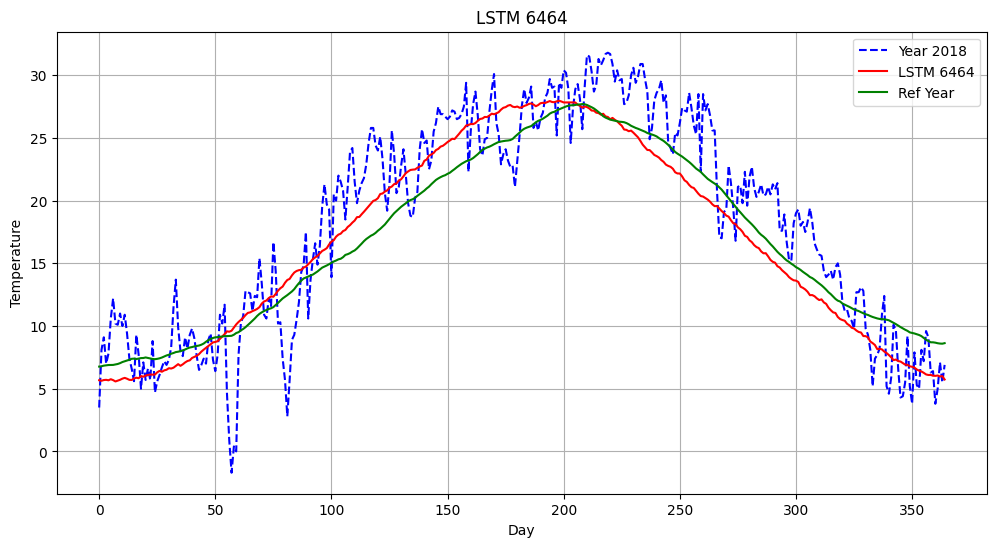

In [11]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_lstm_6464, label="LSTM 6464", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("LSTM 6464")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365)
])

lstm_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_128128 = lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=50)
lstm_128128.save('models/lstm_128128.keras')

Epoch 1/50


2025-03-02 21:34:52.707406: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 243.7311 - mae: 13.1708 - val_loss: 94.7397 - val_mae: 7.9658
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 74.1661 - mae: 7.2611 - val_loss: 83.4584 - val_mae: 7.6315
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 70.8916 - mae: 7.1865 - val_loss: 84.4565 - val_mae: 7.6848
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 70.9135 - mae: 7.1871 - val_loss: 83.9544 - val_mae: 7.6608
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 70.9652 - mae: 7.1897 - val_loss: 84.4524 - val_mae: 7.6851
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 70.8617 - mae: 7.1842 - val_loss: 84.3738 - val_mae: 7.6812
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 70.9436 - mae: 7.1894 - val_loss: 84.0922 - val_mae: 7.6674
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 70.8748 - mae: 7.1851 - val_loss: 85.3546 - val_mae: 7.7318
Epoch 9/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6

In [8]:
from tensorflow.keras.models import load_model
lstm_128128 = load_model('models/lstm_128128.keras')
history_lstm_128128_2 = lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_128128.save('models/lstm_128128.keras')

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 11.0622 - mae: 2.6543 - val_loss: 10.5862 - val_mae: 2.4829
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 10.8505 - mae: 2.6297 - val_loss: 10.3378 - val_mae: 2.4498
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 10.6873 - mae: 2.6095 - val_loss: 10.9468 - val_mae: 2.5202
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 10.6169 - mae: 2.6022 - val_loss: 10.2364 - val_mae: 2.4340
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 10.6786 - mae: 2.6080 - val_loss: 10.3498 - val_mae: 2.4504
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 10.3460 - mae: 2.5658 - val_loss: 10.0373 - val_mae: 2.4275
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 10.2885 - mae: 2.5590 - val_loss: 10.1320 - val_mae: 2.4282
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 10.2061 - mae: 2.5472 - val_loss: 10.1110 - val_mae: 2.4227
Epoch 9/10
137/137 ━━━━━━━━━━━━━

In [9]:
lstm_128128 = tf.keras.models.load_model('models/lstm_128128.keras')
Y_lstm_128128 = lstm_128128.predict(X)
Y_lstm_128128 = Y_lstm_128128.flatten()

mae_lstm_128128 = mean_absolute_error(Y_test, Y_lstm_128128)
print(f'Mean Absolute Error (MAE): {mae_lstm_128128}')

rmse_lstm_128128 = np.sqrt(mean_squared_error(Y_test, Y_lstm_128128))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_128128}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
Mean Absolute Error (MAE): 2.810847571124769
Root Mean Squared Error (RMSE): 3.4491228399786835


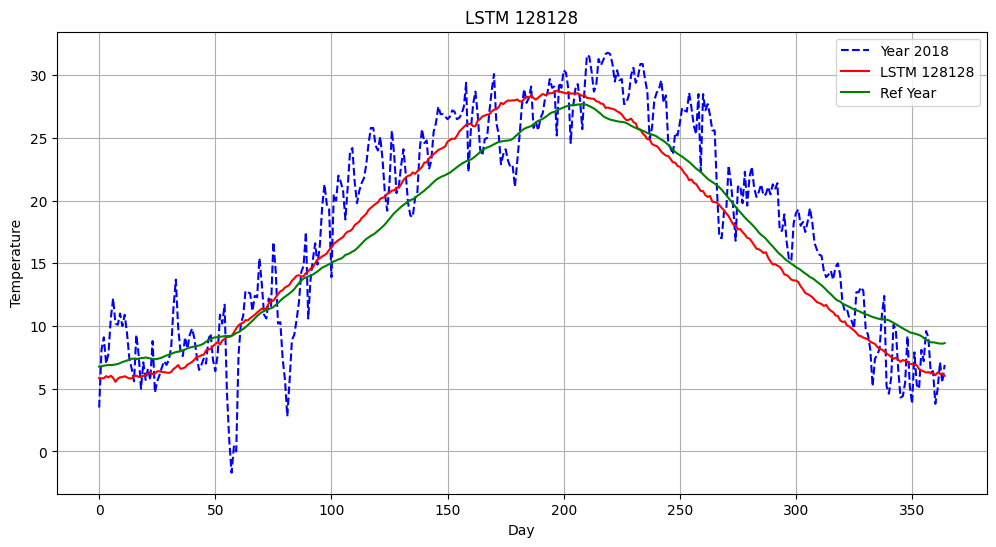

In [10]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_lstm_128128, label="LSTM 128128", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("LSTM 128128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_256256 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dense(365)
])

lstm_256256.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_256256 = lstm_256256.fit(train_ds, validation_data=valid_ds, epochs=50)
lstm_256256.save('models/lstm_256256.keras')

Epoch 1/50


2025-03-02 21:50:21.766780: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 193.9361 - mae: 11.4383 - val_loss: 84.0919 - val_mae: 7.6671
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 70.9753 - mae: 7.1904 - val_loss: 85.0611 - val_mae: 7.7162
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 70.9317 - mae: 7.1894 - val_loss: 88.2254 - val_mae: 7.8723
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 70.9806 - mae: 7.1894 - val_loss: 88.0945 - val_mae: 7.8696
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 71.0975 - mae: 7.1953 - val_loss: 86.9293 - val_mae: 7.8106
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 70.9684 - mae: 7.1885 - val_loss: 88.1861 - val_mae: 7.8719
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 71.0697 - mae: 7.1942 - val_loss: 85.5879 - val_mae: 7.7415
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 70.9558 - mae: 7.1878 - val_loss: 88.8079 - val_mae: 7.8996
Epoch 9/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6

In [8]:
lstm_256256 = tf.keras.models.load_model('models/lstm_256256.keras')
Y_lstm_256256 = lstm_256256.predict(X)
Y_lstm_256256 = Y_lstm_256256.flatten()

mae_lstm_256256 = mean_absolute_error(Y_test, Y_lstm_256256)
print(f'Mean Absolute Error (MAE): {mae_lstm_256256}')

rmse_lstm_256256 = np.sqrt(mean_squared_error(Y_test, Y_lstm_256256))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_256256}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
Mean Absolute Error (MAE): 2.8479613317202217
Root Mean Squared Error (RMSE): 3.537539690834592


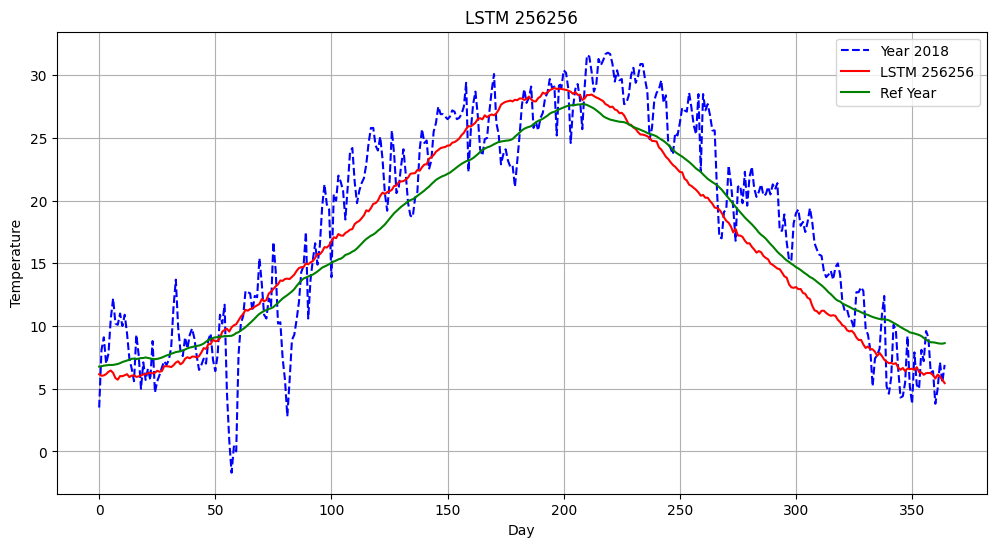

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_lstm_256256, label="LSTM 256256", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("LSTM 256256")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_512512 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(512, return_sequences=True),
    tf.keras.layers.LSTM(512),
    tf.keras.layers.Dense(365)
])

lstm_512512.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_512512 = lstm_512512.fit(train_ds, validation_data=valid_ds, epochs=20)
lstm_512512.save('models/lstm_512512.keras')

Epoch 1/20


2025-03-04 21:25:14.811205: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 155.2361 - mae: 10.1049 - val_loss: 86.2491 - val_mae: 7.7732
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 71.0922 - mae: 7.1945 - val_loss: 89.7052 - val_mae: 7.9393
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 71.0871 - mae: 7.1957 - val_loss: 91.8730 - val_mae: 8.0511
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 71.0334 - mae: 7.1900 - val_loss: 98.0200 - val_mae: 8.3328
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 71.3104 - mae: 7.2016 - val_loss: 93.0342 - val_mae: 8.1041
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 71.2074 - mae: 7.1966 - val_loss: 95.9965 - val_mae: 8.2377
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 71.2241 - mae: 7.1969 - val_loss: 90.0054 - val_mae: 7.9442
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 71.0176 - mae: 7.1885 - val_loss: 88.4360 - val_mae: 7.8725
Epoch 9/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7

In [8]:
from tensorflow.keras.models import load_model
lstm_512512 = load_model('models/lstm_512512.keras')
history_lstm_512512_2 = lstm_512512.fit(train_ds, validation_data=valid_ds, epochs=20)
lstm_512512.save('models/lstm_512512.keras')

Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 71.0732 - mae: 7.1877 - val_loss: 96.8800 - val_mae: 8.2868
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 71.0158 - mae: 7.1835 - val_loss: 93.4710 - val_mae: 8.1063
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 69.4376 - mae: 7.0997 - val_loss: 79.4082 - val_mae: 7.4305
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 66.7909 - mae: 6.9518 - val_loss: 95.9539 - val_mae: 8.2291
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 68.4053 - mae: 7.0439 - val_loss: 76.9225 - val_mae: 7.2975
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 62.9290 - mae: 6.7332 - val_loss: 64.0055 - val_mae: 6.5964
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 54.9914 - mae: 6.2534 - val_loss: 41.5930 - val_mae: 5.1870
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 44.5920 - mae: 5.5319 - val_loss: 23.6240 - val_mae: 3.8088
Epoch 9/20
137/137 ━━━━━━━━━━━━━

In [9]:
lstm_512512 = tf.keras.models.load_model('models/lstm_512512.keras')
Y_lstm_512512 = lstm_512512.predict(X)
Y_lstm_512512 = Y_lstm_512512.flatten()

mae_lstm_512512 = mean_absolute_error(Y_test, Y_lstm_512512)
print(f'Mean Absolute Error (MAE): {mae_lstm_512512}')

rmse_lstm_512512 = np.sqrt(mean_squared_error(Y_test, Y_lstm_512512))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_512512}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
Mean Absolute Error (MAE): 2.7323616754192197
Root Mean Squared Error (RMSE): 3.378892884903199


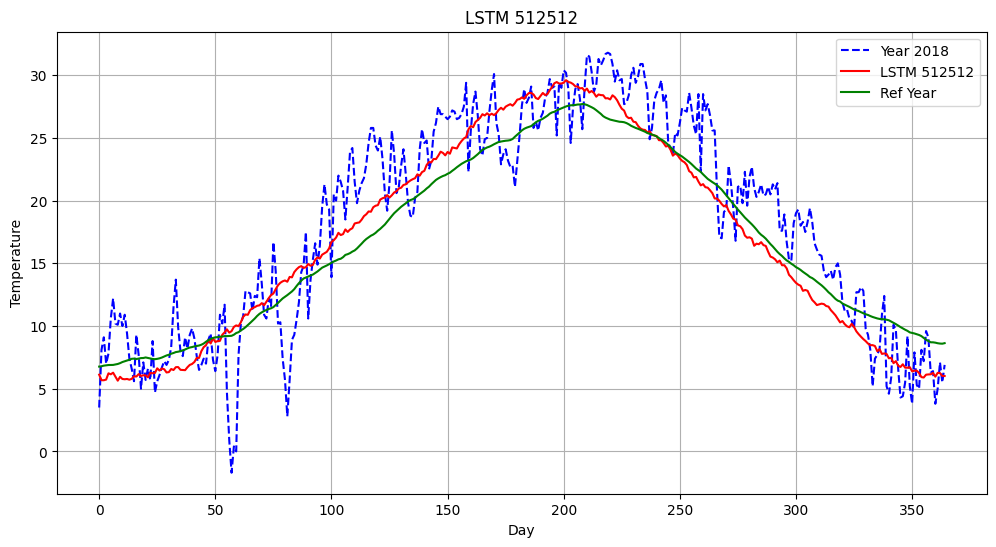

In [10]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_lstm_512512, label="LSTM 512512", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("LSTM 512512")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
gru_32 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365)
])

gru_32.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_32 = gru_32.fit(train_ds, validation_data=valid_ds, epochs=100)
gru_32.save('models/gru_32.keras')

Epoch 1/100


2025-03-02 22:54:27.007202: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 320.6453 - mae: 15.8051 - val_loss: 253.0473 - val_mae: 13.4961
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 202.2418 - mae: 11.8283 - val_loss: 169.9521 - val_mae: 10.6411
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 134.3618 - mae: 9.3341 - val_loss: 123.7558 - val_mae: 8.9505
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 98.4688 - mae: 8.0589 - val_loss: 100.0775 - val_mae: 8.0983
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 81.4917 - mae: 7.4800 - val_loss: 89.3941 - val_mae: 7.7864
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 74.3125 - mae: 7.2549 - val_loss: 84.9331 - val_mae: 7.6515
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 71.8909 - mae: 7.1952 - val_loss: 83.1762 - val_mae: 7.6022
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 71.0664 - mae: 7.1781 - val_loss: 82.6578 - val_mae: 7.5884
Epoch 9/100
137/137 ━━━━━

In [8]:
from tensorflow.keras.models import load_model
gru_32 = load_model('models/gru_32.keras')
history_gru_32_2 = gru_32.fit(train_ds, validation_data=valid_ds, epochs=20)
gru_32.save('models/gru_32.keras')

Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 41.8796 - mae: 5.2937 - val_loss: 31.6175 - val_mae: 4.6580
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 41.5926 - mae: 5.2716 - val_loss: 31.6695 - val_mae: 4.6538
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 41.7788 - mae: 5.2852 - val_loss: 32.1041 - val_mae: 4.6883
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 41.6936 - mae: 5.2805 - val_loss: 31.9117 - val_mae: 4.6676
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 41.5671 - mae: 5.2693 - val_loss: 31.8469 - val_mae: 4.6798
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 41.5319 - mae: 5.2646 - val_loss: 32.0550 - val_mae: 4.6874
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 41.5648 - mae: 5.2672 - val_loss: 31.9392 - val_mae: 4.6852
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 41.0638 - mae: 5.2302 - val_loss: 30.9526 - val_mae: 4.5618
Epoch 9/20
137/137 ━━━━━━━━━━━━━

In [9]:
from tensorflow.keras.models import load_model
gru_32 = load_model('models/gru_32.keras')
history_gru_32_3 = gru_32.fit(train_ds, validation_data=valid_ds, epochs=20)
gru_32.save('models/gru_32.keras')

Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 15.8580 - mae: 3.1561 - val_loss: 21.3928 - val_mae: 3.6806
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 15.0024 - mae: 3.0718 - val_loss: 30.3556 - val_mae: 4.5869
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 14.0667 - mae: 2.9721 - val_loss: 31.4285 - val_mae: 4.6989
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 13.5258 - mae: 2.9183 - val_loss: 27.9986 - val_mae: 4.3898
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 12.9523 - mae: 2.8570 - val_loss: 24.9928 - val_mae: 4.0963
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 12.4449 - mae: 2.8035 - val_loss: 22.6220 - val_mae: 3.8558
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 12.0499 - mae: 2.7607 - val_loss: 25.3369 - val_mae: 4.1618
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 11.6422 - mae: 2.7148 - val_loss: 24.2985 - val_mae: 4.0598
Epoch 9/20
137/137 ━━━━━━━━━━━━━

In [10]:
from tensorflow.keras.models import load_model
gru_32 = load_model('models/gru_32.keras')
history_gru_32_4 = gru_32.fit(train_ds, validation_data=valid_ds, epochs=10)
gru_32.save('models/gru_32.keras')

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 9.9968 - mae: 2.5182 - val_loss: 16.6495 - val_mae: 3.2357
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 9.9422 - mae: 2.5120 - val_loss: 15.7648 - val_mae: 3.1362
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 9.9057 - mae: 2.5085 - val_loss: 15.3086 - val_mae: 3.0684
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 9.8655 - mae: 2.5028 - val_loss: 15.3454 - val_mae: 3.0821
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 9.8659 - mae: 2.5027 - val_loss: 15.4038 - val_mae: 3.0838
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 9.8006 - mae: 2.4952 - val_loss: 15.1859 - val_mae: 3.0618
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 9.7753 - mae: 2.4925 - val_loss: 14.4449 - val_mae: 2.9659
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 9.7508 - mae: 2.4901 - val_loss: 14.5597 - val_mae: 2.9789
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 

In [11]:
gru_32 = tf.keras.models.load_model('models/gru_32.keras')
Y_gru_32 = gru_32.predict(X)
Y_gru_32 = Y_gru_32.flatten()

mae_gru_32 = mean_absolute_error(Y_test, Y_gru_32)
print(f'Mean Absolute Error (MAE): {mae_gru_32}')

rmse_gru_32 = np.sqrt(mean_squared_error(Y_test, Y_gru_32))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_32}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Mean Absolute Error (MAE): 3.0100334690041737
Root Mean Squared Error (RMSE): 3.785314326975058


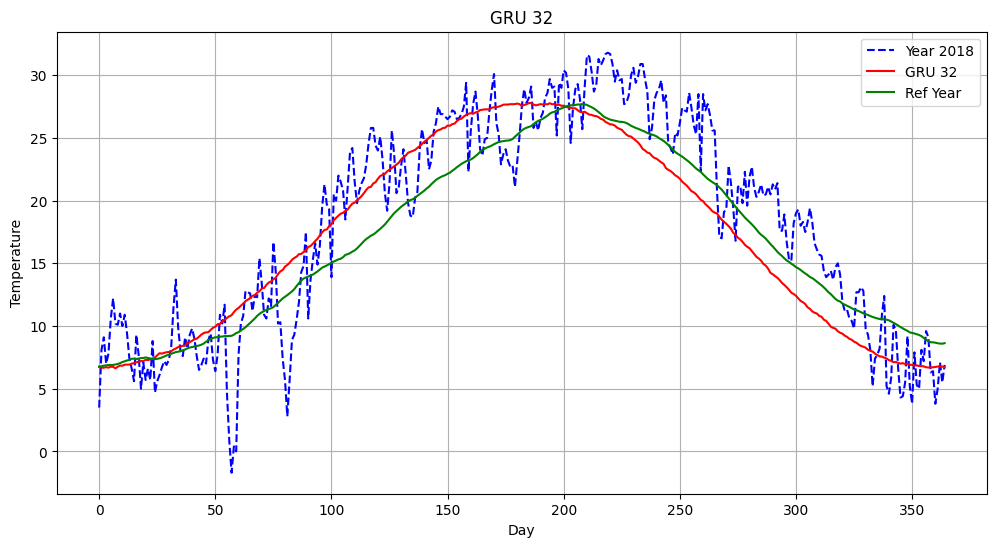

In [12]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_gru_32, label="GRU 32", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("GRU 32")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
gru_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365)
])

gru_64.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_64 = gru_64.fit(train_ds, validation_data=valid_ds, epochs=60)
gru_64.save('models/gru_64.keras')

Epoch 1/60


2025-03-03 00:35:12.156053: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 290.1982 - mae: 14.7954 - val_loss: 169.0067 - val_mae: 10.6144
Epoch 2/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 124.5467 - mae: 8.9830 - val_loss: 99.6479 - val_mae: 8.0852
Epoch 3/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 79.3975 - mae: 7.4139 - val_loss: 85.2207 - val_mae: 7.6649
Epoch 4/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 71.7003 - mae: 7.1905 - val_loss: 82.7284 - val_mae: 7.5901
Epoch 5/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 70.9642 - mae: 7.1832 - val_loss: 82.7506 - val_mae: 7.5983
Epoch 6/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 70.8057 - mae: 7.1806 - val_loss: 82.8198 - val_mae: 7.6029
Epoch 7/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 70.8966 - mae: 7.1872 - val_loss: 82.7284 - val_mae: 7.5987
Epoch 8/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 70.8365 - mae: 7.1837 - val_loss: 83.0581 - val_mae: 7.6157
Epoch 9/60
137/137 ━━━━━━━━━━━━━━━━━━━

In [8]:
gru_64 = tf.keras.models.load_model('models/gru_64.keras')
Y_gru_64 = gru_64.predict(X)
Y_gru_64 = Y_gru_64.flatten()

mae_gru_64 = mean_absolute_error(Y_test, Y_gru_64)
print(f'Mean Absolute Error (MAE): {mae_gru_64}')

rmse_gru_64 = np.sqrt(mean_squared_error(Y_test, Y_gru_64))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_64}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Mean Absolute Error (MAE): 3.155035186401785
Root Mean Squared Error (RMSE): 3.774701830919203


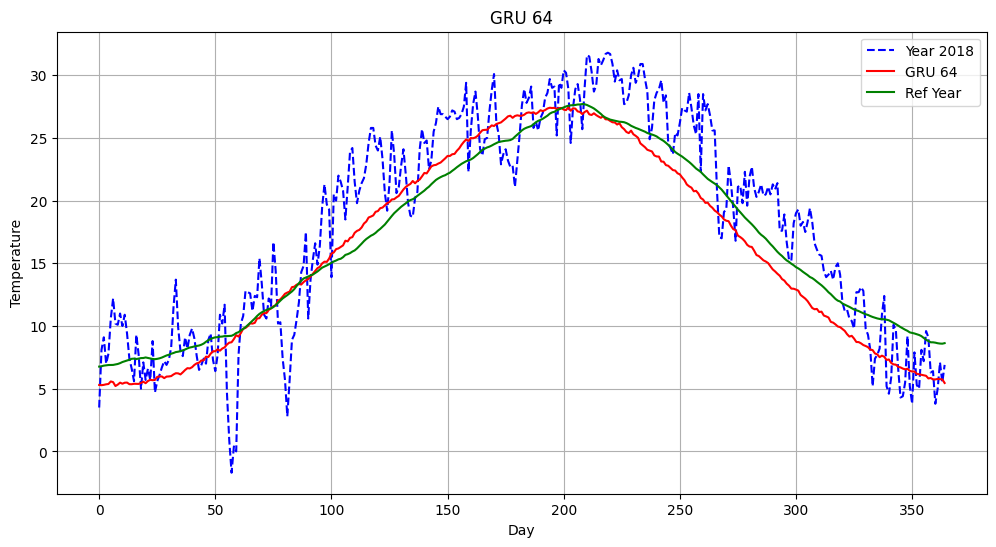

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_gru_64, label="GRU 64", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("GRU 64")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
gru_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365)
])

gru_128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_128 = gru_128.fit(train_ds, validation_data=valid_ds, epochs=50)
gru_128.save('models/gru_128.keras')

Epoch 1/50


2025-03-03 22:10:28.682041: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 246.8879 - mae: 13.2864 - val_loss: 97.6027 - val_mae: 8.0481
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 75.9953 - mae: 7.3138 - val_loss: 83.2572 - val_mae: 7.6186
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 70.8949 - mae: 7.1848 - val_loss: 84.1852 - val_mae: 7.6707
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 70.9083 - mae: 7.1868 - val_loss: 83.7278 - val_mae: 7.6488
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 70.9584 - mae: 7.1894 - val_loss: 84.2514 - val_mae: 7.6747
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 70.8548 - mae: 7.1840 - val_loss: 84.2243 - val_mae: 7.6733
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 70.9372 - mae: 7.1892 - val_loss: 83.8101 - val_mae: 7.6462
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 70.2984 - mae: 7.1526 - val_loss: 82.0278 - val_mae: 7.5613
Epoch 9/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 2

In [8]:
gru_128 = tf.keras.models.load_model('models/gru_128.keras')
Y_gru_128 = gru_128.predict(X)
Y_gru_128 = Y_gru_128.flatten()

mae_gru_128 = mean_absolute_error(Y_test, Y_gru_128)
print(f'Mean Absolute Error (MAE): {mae_gru_128}')

rmse_gru_128 = np.sqrt(mean_squared_error(Y_test, Y_gru_128))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_128}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Mean Absolute Error (MAE): 3.0551384202094924
Root Mean Squared Error (RMSE): 3.8174962479516408


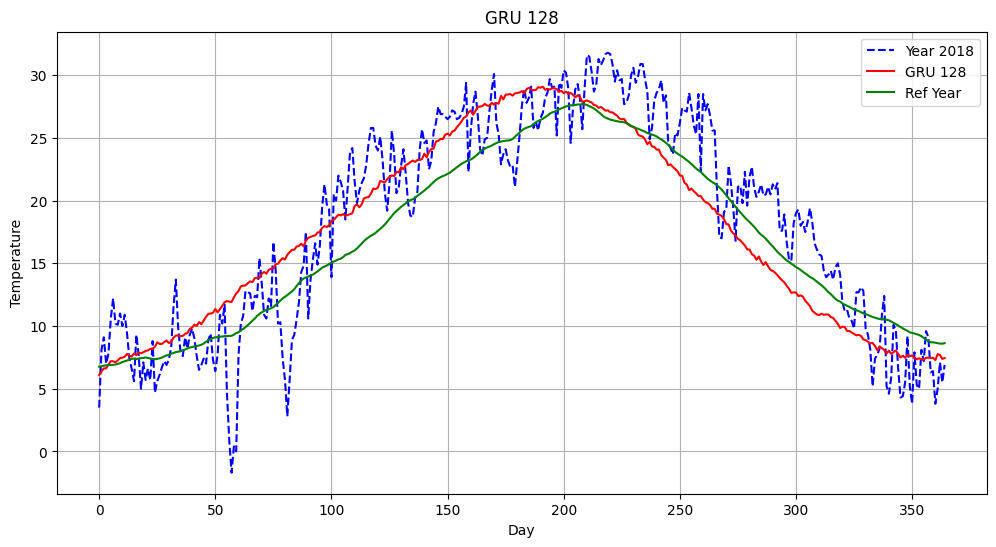

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_gru_128, label="GRU 128", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("GRU 128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
gru_256 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(256),
    tf.keras.layers.Dense(365)
])

gru_256.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_256 = gru_256.fit(train_ds, validation_data=valid_ds, epochs=40)
gru_256.save('models/gru_256.keras')

Epoch 1/40


2025-03-03 22:43:31.543402: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 194.5888 - mae: 11.4623 - val_loss: 83.9594 - val_mae: 7.6608
Epoch 2/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 70.9410 - mae: 7.1885 - val_loss: 84.2404 - val_mae: 7.6766
Epoch 3/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 70.3606 - mae: 7.1578 - val_loss: 82.3278 - val_mae: 7.5827
Epoch 4/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 66.9609 - mae: 6.9659 - val_loss: 73.0446 - val_mae: 7.0956
Epoch 5/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 62.5892 - mae: 6.7149 - val_loss: 64.1892 - val_mae: 6.5987
Epoch 6/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 58.7249 - mae: 6.4847 - val_loss: 58.6699 - val_mae: 6.2780
Epoch 7/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 55.6365 - mae: 6.2966 - val_loss: 53.5904 - val_mae: 5.9652
Epoch 8/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 52.9716 - mae: 6.1234 - val_loss: 49.5832 - val_mae: 5.7226
Epoch 9/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 2

In [8]:
gru_256 = tf.keras.models.load_model('models/gru_256.keras')
Y_gru_256 = gru_256.predict(X)
Y_gru_256 = Y_gru_256.flatten()

mae_gru_256 = mean_absolute_error(Y_test, Y_gru_256)
print(f'Mean Absolute Error (MAE): {mae_gru_256}')

rmse_gru_256 = np.sqrt(mean_squared_error(Y_test, Y_gru_256))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_256}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Mean Absolute Error (MAE): 2.9534289900897295
Root Mean Squared Error (RMSE): 3.7596946179350956


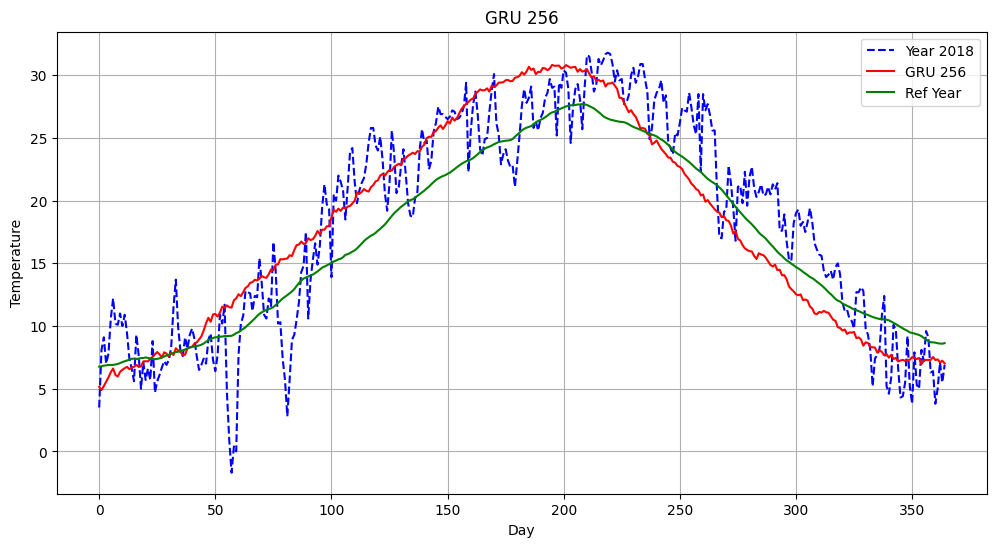

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_gru_256, label="GRU 256", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("GRU 256")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
gru_512 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(512),
    tf.keras.layers.Dense(365)
])

gru_512.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_512 = gru_512.fit(train_ds, validation_data=valid_ds, epochs=20)
gru_512.save('models/gru_512.keras')

Epoch 1/20


2025-03-03 23:02:45.381497: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 150.6518 - mae: 9.9445 - val_loss: 81.5288 - val_mae: 7.5288
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 67.2700 - mae: 6.9802 - val_loss: 53.7611 - val_mae: 5.9511
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 51.3068 - mae: 5.9900 - val_loss: 19.2957 - val_mae: 3.3817
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 18.3562 - mae: 3.4208 - val_loss: 13.6888 - val_mae: 2.8364
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 10.9663 - mae: 2.6461 - val_loss: 15.7795 - val_mae: 3.1047
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 10.4567 - mae: 2.5856 - val_loss: 18.7326 - val_mae: 3.4854
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 10.1772 - mae: 2.5500 - val_loss: 16.0807 - val_mae: 3.1866
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 9.9430 - mae: 2.5196 - val_loss: 14.9280 - val_mae: 3.0487
Epoch 9/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 

In [8]:
gru_512 = tf.keras.models.load_model('models/gru_512.keras')
Y_gru_512 = gru_512.predict(X)
Y_gru_512 = Y_gru_512.flatten()

mae_gru_512 = mean_absolute_error(Y_test, Y_gru_512)
print(f'Mean Absolute Error (MAE): {mae_gru_512}')

rmse_gru_512 = np.sqrt(mean_squared_error(Y_test, Y_gru_512))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_512}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Mean Absolute Error (MAE): 3.0406597126999944
Root Mean Squared Error (RMSE): 3.823153955762654


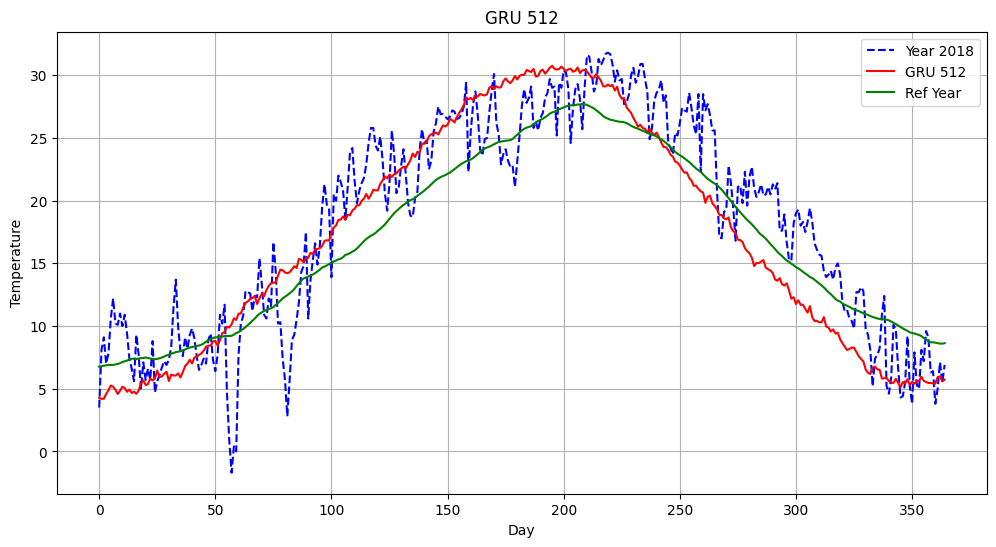

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_gru_512, label="GRU 512", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("GRU 512")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [ ]:
gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365)
])

gru_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_3232 = gru_3232.fit(train_ds, validation_data=valid_ds, epochs=100)
gru_3232.save('models/gru_3232.keras')

Epoch 1/100


2025-03-03 23:36:52.763369: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 318.8153 - mae: 15.7446 - val_loss: 246.7107 - val_mae: 13.2854
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 195.8686 - mae: 11.5973 - val_loss: 164.9642 - val_mae: 10.4512
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 129.5078 - mae: 9.1571 - val_loss: 120.7489 - val_mae: 8.8382
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 95.5144 - mae: 7.9568 - val_loss: 98.6240 - val_mae: 8.0545
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 79.9866 - mae: 7.4307 - val_loss: 88.8728 - val_mae: 7.7704
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 73.6744 - mae: 7.2374 - val_loss: 84.8358 - val_mae: 7.6529
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 71.6641 - mae: 7.1907 - val_loss: 83.2132 - val_mae: 7.6058
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 70.9995 - mae: 7.1777 - val_loss: 82.7158 - val_mae: 7.5912
Epoch 9/100
137/137 ━━━━━

In [8]:
gru_3232 = tf.keras.models.load_model('models/gru_3232.keras')
Y_gru_3232 = gru_3232.predict(X)
Y_gru_3232 = Y_gru_3232.flatten()

mae_gru_3232 = mean_absolute_error(Y_test, Y_gru_3232)
print(f'Mean Absolute Error (MAE): {mae_gru_3232}')

rmse_gru_3232 = np.sqrt(mean_squared_error(Y_test, Y_gru_3232))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_3232}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
Mean Absolute Error (MAE): 2.7400123711154882
Root Mean Squared Error (RMSE): 3.3416402678480557


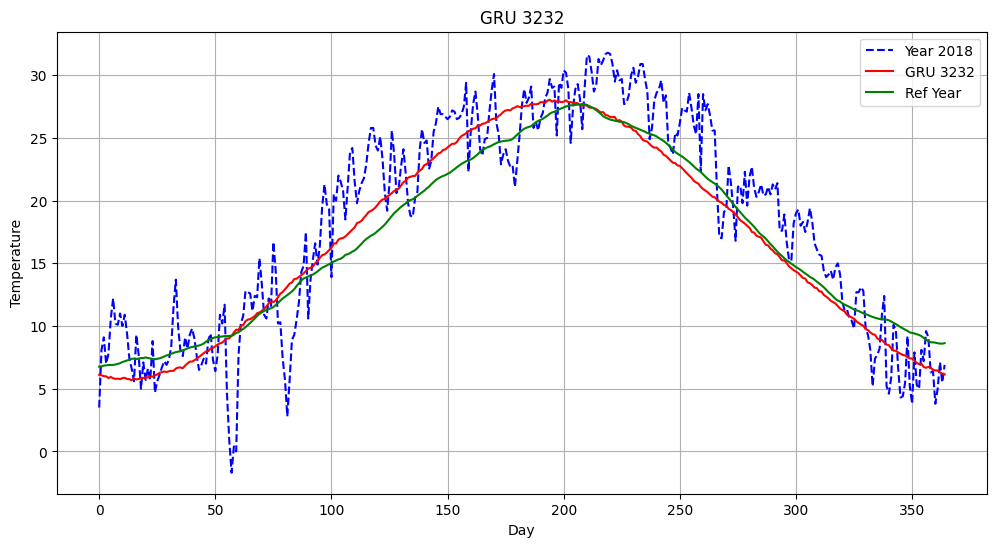

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_gru_3232, label="GRU 3232", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("GRU 3232")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365)
])

gru_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_6464 = gru_6464.fit(train_ds, validation_data=valid_ds, epochs=60)
gru_6464.save('models/gru_6464.keras')

Epoch 1/60


2025-03-04 18:38:32.544829: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 290.1177 - mae: 14.7878 - val_loss: 165.8772 - val_mae: 10.4684
Epoch 2/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 121.8432 - mae: 8.8862 - val_loss: 98.6648 - val_mae: 8.0631
Epoch 3/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 78.5408 - mae: 7.3870 - val_loss: 85.1852 - val_mae: 7.6758
Epoch 4/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 71.5715 - mae: 7.1883 - val_loss: 82.7900 - val_mae: 7.5974
Epoch 5/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 70.9553 - mae: 7.1838 - val_loss: 82.7878 - val_mae: 7.6012
Epoch 6/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 70.8071 - mae: 7.1809 - val_loss: 82.8427 - val_mae: 7.6043
Epoch 7/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 70.8976 - mae: 7.1873 - val_loss: 82.7448 - val_mae: 7.5996
Epoch 8/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 70.8372 - mae: 7.1837 - val_loss: 83.0826 - val_mae: 7.6171
Epoch 9/60
137/137 ━━━━━━━━━━━━━━━━━━━

In [8]:
gru_6464 = tf.keras.models.load_model('models/gru_6464.keras')
Y_gru_6464 = gru_6464.predict(X)
Y_gru_6464 = Y_gru_6464.flatten()

mae_gru_6464 = mean_absolute_error(Y_test, Y_gru_6464)
print(f'Mean Absolute Error (MAE): {mae_gru_6464}')

rmse_gru_6464 = np.sqrt(mean_squared_error(Y_test, Y_gru_6464))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_6464}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Mean Absolute Error (MAE): 2.787152326400966
Root Mean Squared Error (RMSE): 3.4300955805305477


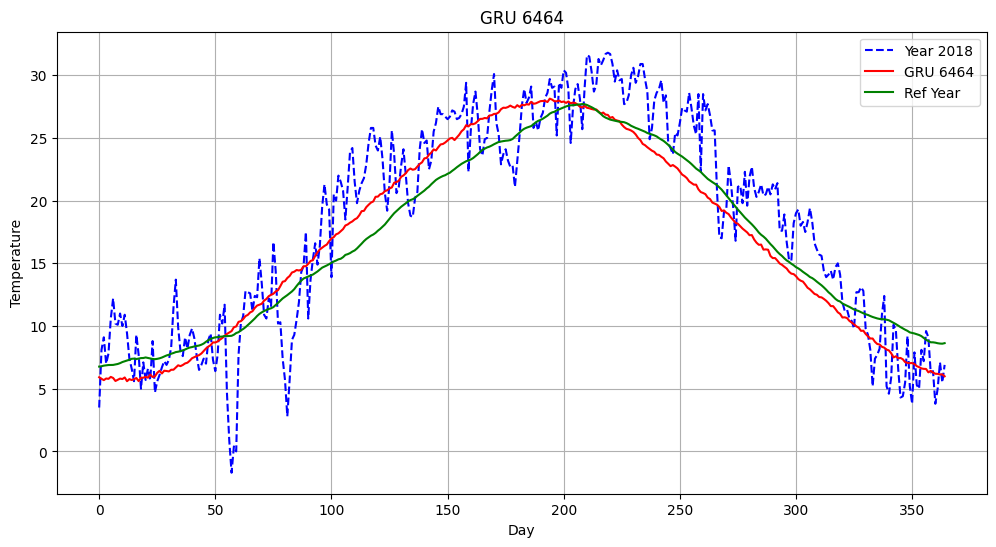

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_gru_6464, label="GRU 6464", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("GRU 6464")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365)
])

gru_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_128128 = gru_128128.fit(train_ds, validation_data=valid_ds, epochs=50)
gru_128128.save('models/gru_128128.keras')

Epoch 1/50


2025-03-04 19:19:22.749473: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 245.5742 - mae: 13.2414 - val_loss: 97.9513 - val_mae: 8.0817
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 75.5752 - mae: 7.3018 - val_loss: 83.5137 - val_mae: 7.6326
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 70.8975 - mae: 7.1854 - val_loss: 84.2407 - val_mae: 7.6739
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 70.9094 - mae: 7.1869 - val_loss: 83.7713 - val_mae: 7.6513
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 70.9598 - mae: 7.1895 - val_loss: 84.2813 - val_mae: 7.6765
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 70.8561 - mae: 7.1840 - val_loss: 84.2411 - val_mae: 7.6745
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 70.9395 - mae: 7.1893 - val_loss: 83.9960 - val_mae: 7.6626
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 70.8710 - mae: 7.1850 - val_loss: 85.1556 - val_mae: 7.7218
Epoch 9/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6

In [8]:
gru_128128 = tf.keras.models.load_model('models/gru_128128.keras')
Y_gru_128128 = gru_128128.predict(X)
Y_gru_128128 = Y_gru_128128.flatten()

mae_gru_128128 = mean_absolute_error(Y_test, Y_gru_128128)
print(f'Mean Absolute Error (MAE): {mae_gru_128128}')

rmse_gru_128128 = np.sqrt(mean_squared_error(Y_test, Y_gru_128128))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_128128}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
Mean Absolute Error (MAE): 3.165135714648521
Root Mean Squared Error (RMSE): 3.8813485190847663


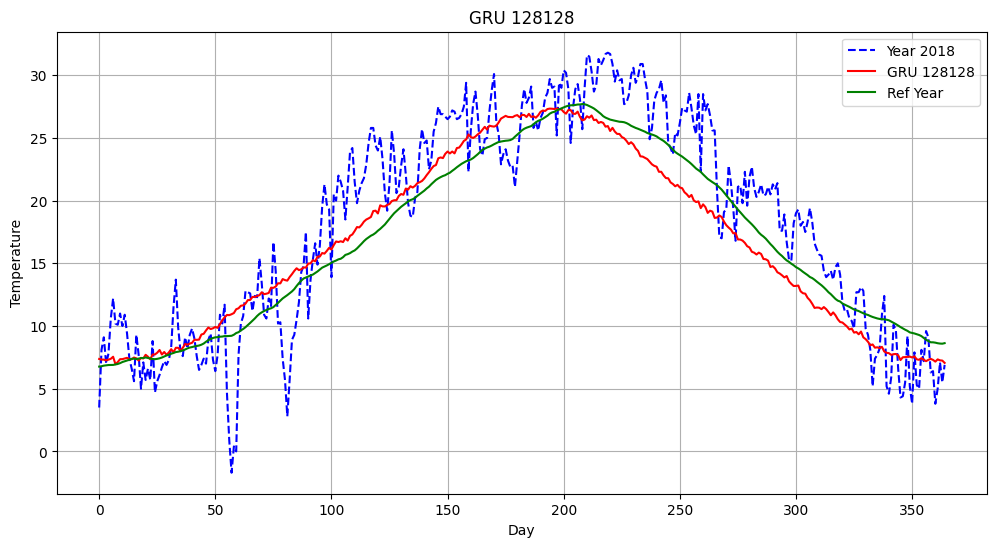

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_gru_128128, label="GRU 128128", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("GRU 128128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
gru_256256 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(256, return_sequences=True),
    tf.keras.layers.GRU(256),
    tf.keras.layers.Dense(365)
])

gru_256256.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_256256 = gru_256256.fit(train_ds, validation_data=valid_ds, epochs=30)
gru_256256.save('models/gru_256256.keras')

Epoch 1/30


2025-03-05 00:32:52.759023: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 192.0499 - mae: 11.3773 - val_loss: 84.0417 - val_mae: 7.6640
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 70.9713 - mae: 7.1901 - val_loss: 84.9521 - val_mae: 7.7109
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 70.9282 - mae: 7.1892 - val_loss: 87.9737 - val_mae: 7.8598
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 70.9761 - mae: 7.1893 - val_loss: 87.7968 - val_mae: 7.8544
Epoch 5/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 71.0877 - mae: 7.1949 - val_loss: 86.8139 - val_mae: 7.8039
Epoch 6/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 70.9623 - mae: 7.1883 - val_loss: 87.9517 - val_mae: 7.8595
Epoch 7/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 71.0624 - mae: 7.1939 - val_loss: 85.5337 - val_mae: 7.7387
Epoch 8/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 70.9532 - mae: 7.1877 - val_loss: 88.7575 - val_mae: 7.8970
Epoch 9/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 6

In [8]:
gru_256256 = tf.keras.models.load_model('models/gru_256256.keras')
Y_gru_256256 = gru_256256.predict(X)
Y_gru_256256 = Y_gru_256256.flatten()

mae_gru_256256 = mean_absolute_error(Y_test, Y_gru_256256)
print(f'Mean Absolute Error (MAE): {mae_gru_256256}')

rmse_gru_256256 = np.sqrt(mean_squared_error(Y_test, Y_gru_256256))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_256256}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
Mean Absolute Error (MAE): 3.119948912320072
Root Mean Squared Error (RMSE): 3.9294290884295293


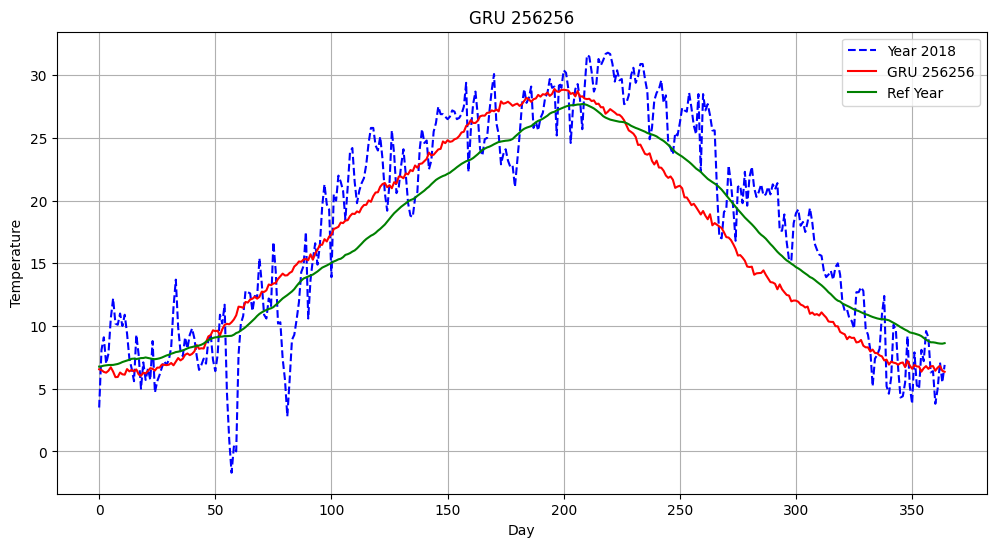

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_gru_256256, label="GRU 256256", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("GRU 256256")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
gru_512512 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(512, return_sequences=True),
    tf.keras.layers.GRU(512),
    tf.keras.layers.Dense(365)
])

gru_512512.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_512512 = gru_512512.fit(train_ds, validation_data=valid_ds, epochs=20)
gru_512512.save('models/gru_512512.keras')

Epoch 1/20


2025-03-04 21:11:59.344335: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 149.4163 - mae: 9.9063 - val_loss: 86.0935 - val_mae: 7.7651
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 70.7325 - mae: 7.1737 - val_loss: 68.1520 - val_mae: 6.8393
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 55.0338 - mae: 6.2343 - val_loss: 22.1051 - val_mae: 3.6099
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 40.7398 - mae: 5.2108 - val_loss: 12.7221 - val_mae: 2.8192
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 17.6654 - mae: 3.3468 - val_loss: 18.4949 - val_mae: 3.4361
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 11.1707 - mae: 2.6714 - val_loss: 28.1505 - val_mae: 4.4574
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 10.5241 - mae: 2.5930 - val_loss: 18.8669 - val_mae: 3.5006
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 10.0600 - mae: 2.5328 - val_loss: 11.7858 - val_mae: 2.6444
Epoch 9/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s

In [8]:
gru_512512 = tf.keras.models.load_model('models/gru_512512.keras')
Y_gru_512512 = gru_512512.predict(X)
Y_gru_512512 = Y_gru_512512.flatten()

mae_gru_512512 = mean_absolute_error(Y_test, Y_gru_512512)
print(f'Mean Absolute Error (MAE): {mae_gru_512512}')

rmse_gru_512512 = np.sqrt(mean_squared_error(Y_test, Y_gru_512512))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_512512}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
Mean Absolute Error (MAE): 3.2287140741740186
Root Mean Squared Error (RMSE): 4.133811589246496


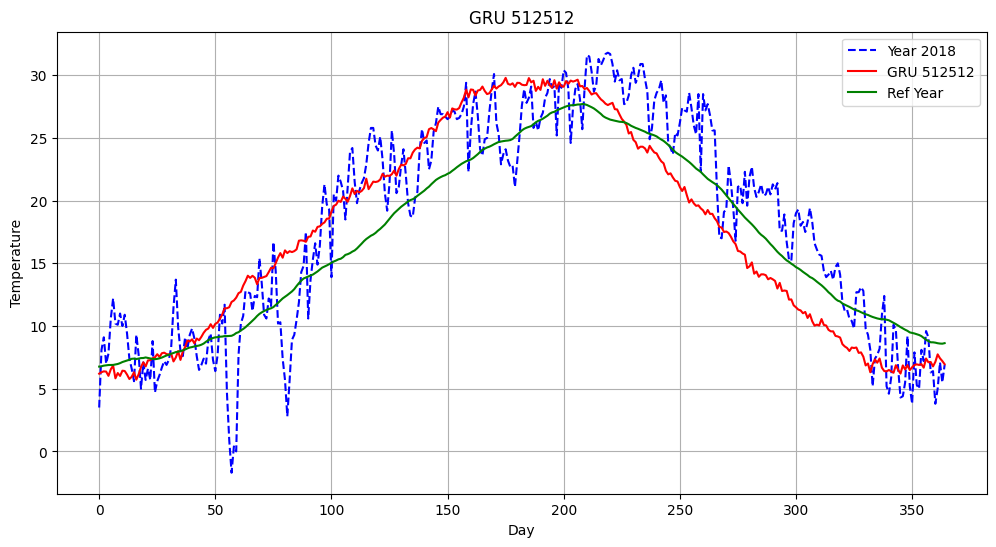

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_gru_512512, label="GRU 512512", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("GRU 512512")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365)
])

lstm_gru_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_gru_3232 = lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=100)
lstm_gru_3232.save('models/lstm_gru_3232.keras')

Epoch 1/100


2025-03-04 22:02:24.187324: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 318.6395 - mae: 15.7339 - val_loss: 238.9554 - val_mae: 13.0344
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 188.9358 - mae: 11.3445 - val_loss: 158.3632 - val_mae: 10.2109
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 124.2465 - mae: 8.9674 - val_loss: 116.4232 - val_mae: 8.6879
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 92.3952 - mae: 7.8499 - val_loss: 96.1871 - val_mae: 7.9798
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 78.4602 - mae: 7.3823 - val_loss: 87.6584 - val_mae: 7.7285
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 73.0535 - mae: 7.2206 - val_loss: 84.2781 - val_mae: 7.6340
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 71.4552 - mae: 7.1867 - val_loss: 82.9669 - val_mae: 7.5961
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 70.9423 - mae: 7.1778 - val_loss: 82.6185 - val_mae: 7.5872
Epoch 9/100
137/137 ━━━━━━

In [8]:
lstm_gru_3232 = tf.keras.models.load_model('models/lstm_gru_3232.keras')
Y_lstm_gru_3232 = lstm_gru_3232.predict(X)
Y_lstm_gru_3232 = Y_lstm_gru_3232.flatten()

mae_lstm_gru_3232 = mean_absolute_error(Y_test, Y_lstm_gru_3232)
print(f'Mean Absolute Error (MAE): {mae_lstm_gru_3232}')

rmse_lstm_gru_3232 = np.sqrt(mean_squared_error(Y_test, Y_lstm_gru_3232))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_gru_3232}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
Mean Absolute Error (MAE): 2.608135007309587
Root Mean Squared Error (RMSE): 3.2441892344942733


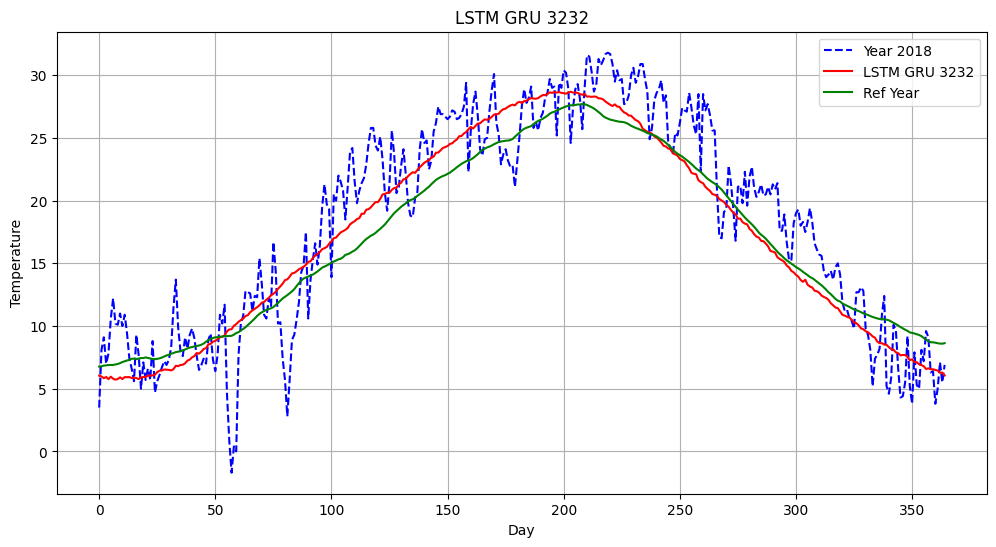

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_lstm_gru_3232, label="LSTM GRU 3232", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("LSTM GRU 3232")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365)
])

lstm_gru_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_gru_6464= lstm_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=70)
lstm_gru_6464.save('models/lstm_gru_6464.keras')

Epoch 1/70


2025-03-04 22:44:04.720820: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 289.5356 - mae: 14.7610 - val_loss: 159.9857 - val_mae: 10.2682
Epoch 2/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 116.6179 - mae: 8.6991 - val_loss: 96.6564 - val_mae: 8.0039
Epoch 3/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 77.0005 - mae: 7.3385 - val_loss: 84.9285 - val_mae: 7.6670
Epoch 4/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 71.3548 - mae: 7.1844 - val_loss: 82.8057 - val_mae: 7.5957
Epoch 5/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 70.9415 - mae: 7.1846 - val_loss: 82.8374 - val_mae: 7.6031
Epoch 6/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 70.8087 - mae: 7.1812 - val_loss: 82.8985 - val_mae: 7.6069
Epoch 7/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 70.8994 - mae: 7.1874 - val_loss: 82.7946 - val_mae: 7.6020
Epoch 8/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 70.8386 - mae: 7.1838 - val_loss: 83.1530 - val_mae: 7.6206
Epoch 9/70
137/137 ━━━━━━━━━━━━━━━━━━━

In [8]:
lstm_gru_6464 = tf.keras.models.load_model('models/lstm_gru_6464.keras')
Y_lstm_gru_6464 = lstm_gru_6464.predict(X)
Y_lstm_gru_6464 = Y_lstm_gru_6464.flatten()

mae_lstm_gru_6464 = mean_absolute_error(Y_test, Y_lstm_gru_6464)
print(f'Mean Absolute Error (MAE): {mae_lstm_gru_6464}')

rmse_lstm_gru_6464 = np.sqrt(mean_squared_error(Y_test, Y_lstm_gru_6464))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_gru_6464}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
Mean Absolute Error (MAE): 2.8209943146901586
Root Mean Squared Error (RMSE): 3.510531044750725


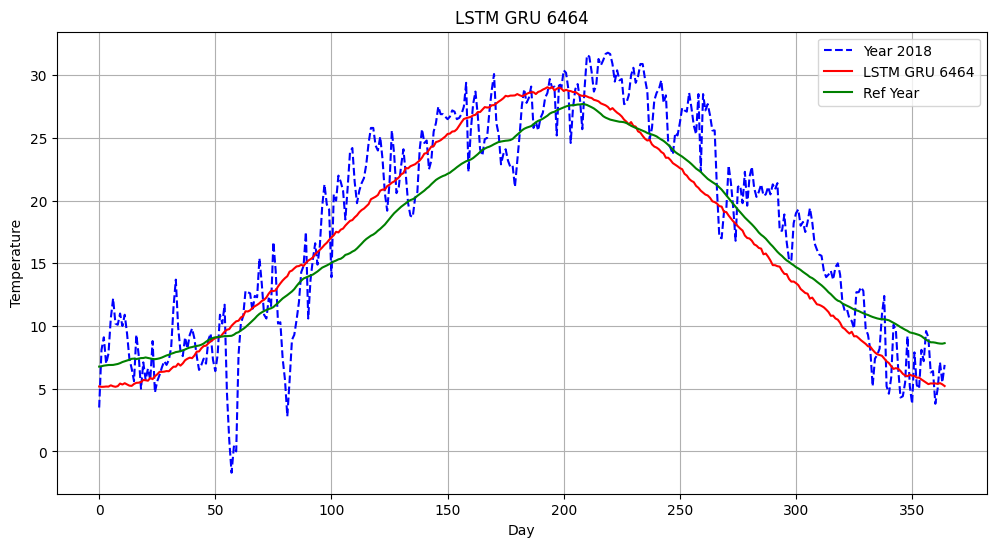

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_lstm_gru_6464, label="LSTM GRU 6464", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("LSTM GRU 6464")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365)
])

lstm_gru_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_gru_128128= lstm_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=50)
lstm_gru_128128.save('models/lstm_gru_128128.keras')

Epoch 1/50


2025-03-04 23:07:25.617223: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 243.7621 - mae: 13.1775 - val_loss: 96.8376 - val_mae: 8.0448
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 74.8957 - mae: 7.2816 - val_loss: 83.5289 - val_mae: 7.6331
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 70.8941 - mae: 7.1858 - val_loss: 84.3245 - val_mae: 7.6774
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 70.9109 - mae: 7.1869 - val_loss: 83.8449 - val_mae: 7.6545
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 70.9618 - mae: 7.1895 - val_loss: 84.3517 - val_mae: 7.6793
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 70.8581 - mae: 7.1841 - val_loss: 84.2951 - val_mae: 7.6763
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 70.9411 - mae: 7.1894 - val_loss: 84.0347 - val_mae: 7.6638
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 70.8724 - mae: 7.1850 - val_loss: 85.2409 - val_mae: 7.7252
Epoch 9/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 5

In [8]:
lstm_gru_128128 = tf.keras.models.load_model('models/lstm_gru_128128.keras')
Y_lstm_gru_128128 = lstm_gru_128128.predict(X)
Y_lstm_gru_128128 = Y_lstm_gru_128128.flatten()

mae_lstm_gru_128128 = mean_absolute_error(Y_test, Y_lstm_gru_128128)
print(f'Mean Absolute Error (MAE): {mae_lstm_gru_128128}')

rmse_lstm_gru_128128 = np.sqrt(mean_squared_error(Y_test, Y_lstm_gru_128128))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_gru_128128}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
Mean Absolute Error (MAE): 2.549038565648745
Root Mean Squared Error (RMSE): 3.2412280095966315


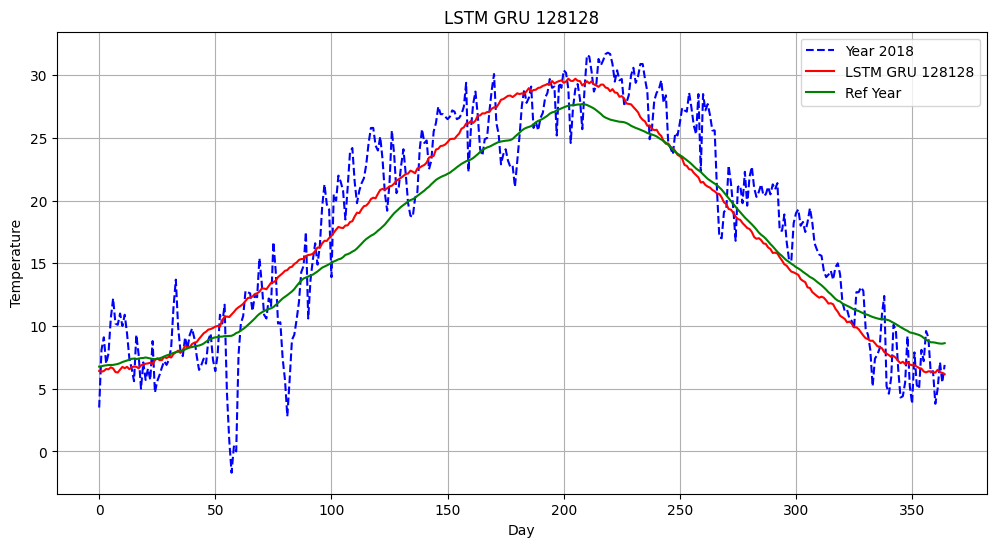

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_lstm_gru_128128, label="LSTM GRU 128128", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("LSTM GRU 128128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_gru_256256 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.GRU(256),
    tf.keras.layers.Dense(365)
])

lstm_gru_256256.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_gru_256256= lstm_gru_256256.fit(train_ds, validation_data=valid_ds, epochs=40)
lstm_gru_256256.save('models/lstm_gru_256256.keras')

Epoch 1/40


2025-03-04 23:47:59.565143: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 192.3051 - mae: 11.3834 - val_loss: 84.1165 - val_mae: 7.6671
Epoch 2/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 70.9735 - mae: 7.1902 - val_loss: 84.9924 - val_mae: 7.7126
Epoch 3/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 70.9299 - mae: 7.1893 - val_loss: 88.0975 - val_mae: 7.8660
Epoch 4/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 70.9783 - mae: 7.1894 - val_loss: 87.9540 - val_mae: 7.8623
Epoch 5/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 71.0931 - mae: 7.1951 - val_loss: 86.8833 - val_mae: 7.8077
Epoch 6/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 70.9659 - mae: 7.1884 - val_loss: 88.1017 - val_mae: 7.8673
Epoch 7/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 71.0671 - mae: 7.1941 - val_loss: 85.5699 - val_mae: 7.7409
Epoch 8/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 70.9549 - mae: 7.1877 - val_loss: 88.7906 - val_mae: 7.8988
Epoch 9/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 7

In [8]:
lstm_gru_256256 = tf.keras.models.load_model('models/lstm_gru_256256.keras')
Y_lstm_gru_256256 = lstm_gru_256256.predict(X)
Y_lstm_gru_256256 = Y_lstm_gru_256256.flatten()

mae_lstm_gru_256256 = mean_absolute_error(Y_test, Y_lstm_gru_256256)
print(f'Mean Absolute Error (MAE): {mae_lstm_gru_256256}')

rmse_lstm_gru_256256 = np.sqrt(mean_squared_error(Y_test, Y_lstm_gru_256256))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_gru_256256}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
Mean Absolute Error (MAE): 2.736500846131207
Root Mean Squared Error (RMSE): 3.3638140472200972


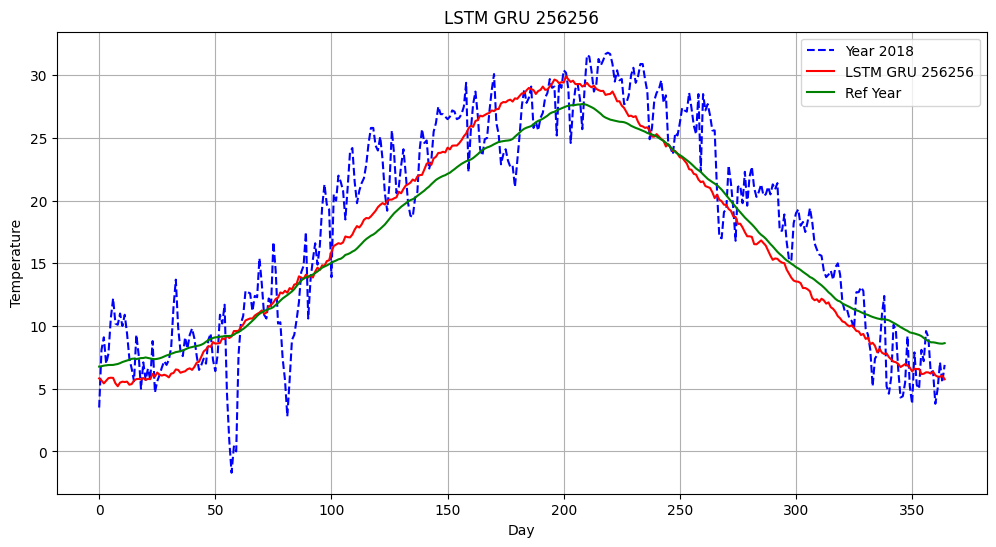

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_lstm_gru_256256, label="LSTM GRU 256256", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("LSTM GRU 256256")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_gru_512512 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(512, return_sequences=True),
    tf.keras.layers.GRU(512),
    tf.keras.layers.Dense(365)
])

lstm_gru_512512.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_gru_512512 = lstm_gru_512512.fit(train_ds, validation_data=valid_ds, epochs=30)
lstm_gru_512512.save('models/lstm_gru_512512.keras')

Epoch 1/30


2025-03-05 00:01:06.200880: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 149.6475 - mae: 9.9125 - val_loss: 86.3321 - val_mae: 7.7776
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 71.0988 - mae: 7.1948 - val_loss: 90.1350 - val_mae: 7.9595
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 71.1007 - mae: 7.1962 - val_loss: 91.7529 - val_mae: 8.0442
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 71.0342 - mae: 7.1900 - val_loss: 98.5130 - val_mae: 8.3542
Epoch 5/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 71.3162 - mae: 7.2016 - val_loss: 93.5333 - val_mae: 8.1274
Epoch 6/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 71.2271 - mae: 7.1971 - val_loss: 96.1883 - val_mae: 8.2461
Epoch 7/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 71.2240 - mae: 7.1966 - val_loss: 90.3913 - val_mae: 7.9628
Epoch 8/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 71.0242 - mae: 7.1887 - val_loss: 88.4205 - val_mae: 7.8699
Epoch 9/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s

In [8]:
lstm_gru_512512 = tf.keras.models.load_model('models/lstm_gru_512512.keras')
Y_lstm_gru_512512 = lstm_gru_512512.predict(X)
Y_lstm_gru_512512 = Y_lstm_gru_512512.flatten()

mae_lstm_gru_512512 = mean_absolute_error(Y_test, Y_lstm_gru_512512)
print(f'Mean Absolute Error (MAE): {mae_lstm_gru_512512}')

rmse_lstm_gru_512512 = np.sqrt(mean_squared_error(Y_test, Y_lstm_gru_512512))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_gru_512512}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
Mean Absolute Error (MAE): 2.923946093729097
Root Mean Squared Error (RMSE): 3.6590589138400738


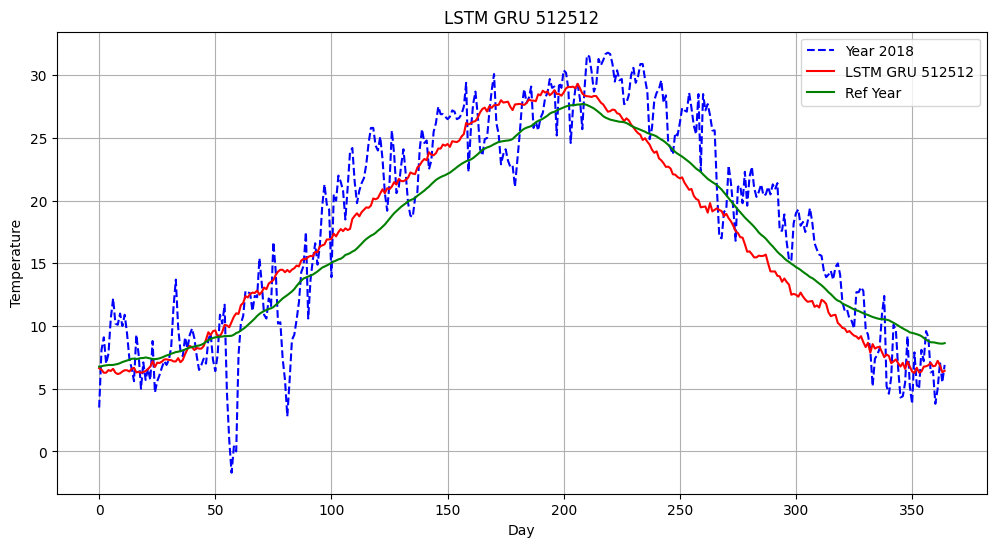

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_lstm_gru_512512, label="LSTM GRU 512512", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("LSTM GRU 512512")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 